In [9]:
import pickle

with open("Data/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("Data/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("Data/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("Data/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print("Train/test sets loaded successfully.")



Train/test sets loaded successfully.


## Pipeline 

In [10]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# -----------------------------
# 2️⃣ Preprocessing
# -----------------------------
numeric_features = ['Mileage_per_Year', 'Log_Mileage', 'Mileage_Delta', 'Owners_per_Year', 'Engine']
categorical_features = [col for col in X_train.columns if col not in numeric_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

# -----------------------------
# 3️⃣ Build pipeline
# -----------------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# -----------------------------
# 4️⃣ Hyperparameter grid
# -----------------------------
param_grid = {
    'regressor__n_estimators': [200, 500, 800],
    'regressor__max_depth': [None, 20, 25],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 0.5, 0.7]
}

# -----------------------------
# 5️⃣ Randomized Search
# -----------------------------
scoring = {
    'R2':'r2',
    'MAE':'neg_mean_absolute_error',
    'RMSE':'neg_root_mean_squared_error'
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=50,         # try 50 random combinations
    cv=5,
    scoring=scoring,
    refit='R2',        # refit model using R²
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# -----------------------------
# 6️⃣ Fit model
# -----------------------------
random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Train R²:", random_search.score(X_train, y_train))
print("Test R²:", random_search.score(X_test, y_test))

# -----------------------------
# 7️⃣ Predict and evaluate in £
# -----------------------------
y_pred_log = random_search.predict(X_test)
y_test_actual = np.exp(y_test)
y_pred_actual = np.exp(y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print("RMSE (£):", rmse)
print("MAE (£):", mae)
print("R²:", r2)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'regressor__n_estimators': 800, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5, 'regressor__max_depth': 20}
Train R²: 0.9775822211801022
Test R²: 0.8738736381031221
RMSE (£): 1325.2777836710302
MAE (£): 772.9893369074907
R²: 0.9175062163533795


In [14]:
import joblib

# Save trained pipeline or grid search
joblib.dump(random_search, "Data/vehicle_model.pkl")


['Data/vehicle_model.pkl']

In [12]:
# Get the preprocessor from your pipeline
preprocessor = pipeline.named_steps['preprocessor']

# Numeric features are scaled, categorical are passthrough
numeric_features = ['Mileage_per_Year', 'Log_Mileage', 'Mileage_Delta', 'Owners_per_Year', 'Engine']
categorical_features = [col for col in X_test.columns if col not in numeric_features]

# ColumnTransformer preserves order: numeric first, then passthrough categoricals
feature_names = numeric_features + categorical_features


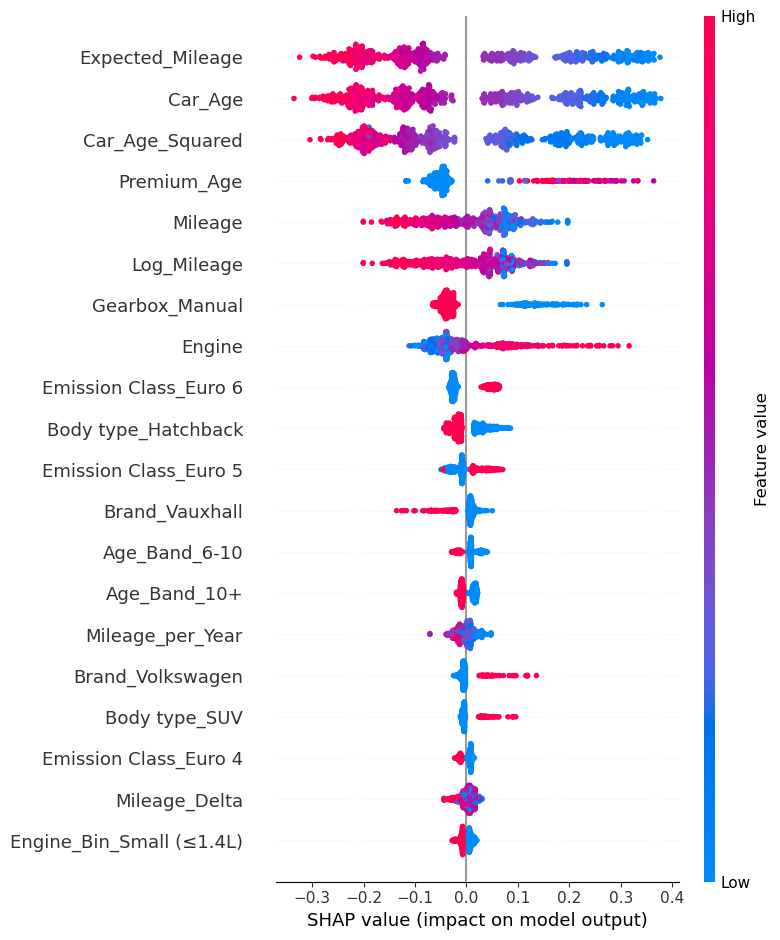

In [13]:
# Get the fitted pipeline from your RandomizedSearchCV
best_pipeline = random_search.best_estimator_

# Preprocess test data using the fitted pipeline
X_test_preprocessed = best_pipeline.named_steps['preprocessor'].transform(X_test)

# Get the trained regressor
rf_model = best_pipeline.named_steps['regressor']

# SHAP explainer
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_preprocessed)

# Feature names
numeric_features = ['Mileage_per_Year', 'Log_Mileage', 'Mileage_Delta', 'Owners_per_Year', 'Engine']
categorical_features = [col for col in X_test.columns if col not in numeric_features]
feature_names = numeric_features + categorical_features

# SHAP summary plot
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, max_display=20)
